# Proveedores

In [10]:
import pandas as pd
import numpy as np
import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import time
import networkx as nx

# Greedy para selección de proveedores

Generando soluciones iniciales...

--- Análisis de Solución Greedy Básica ---
Costo total: 62050.00
Costo de compra: 44050.00
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Análisis de Solución Greedy Mejorada ---
Costo total: 62200.00
Costo de compra: 44200.00
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

Ejecutando algoritmo genético...
gen	nevals	min   	avg	std
0  	100   	62,050	inf	nan
1  	77    	62,050	inf	nan
2  	76    	62,050	62,332.4	227.54
3  	77    	62,050	62,166.4	127.408
4  	62    	62,050	62,101.4	102.944
5  	75    	62,050	62,089.2	123.103
6  	70    	62,050	62,072.5	85.6193
7  	80    	62,050	62,074.3	101.605
8  	73    	62,050	62,099.2	166.156
9  	85    	62,050	62,086.6	124.76 
10 	74    	62,050	62,078.7	98.2088
11 	73    	62,050	62,093.1	138.5  
12 	75    	62,050	62,089.8	128.556
13 	

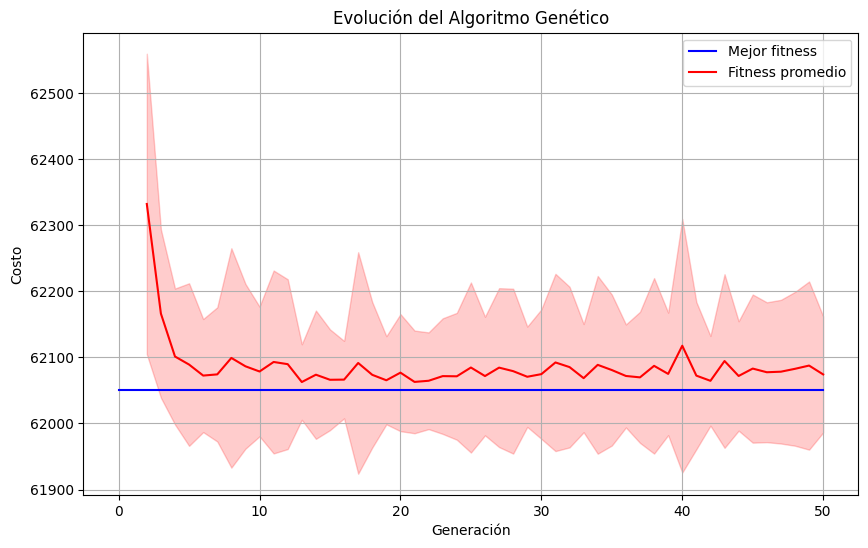

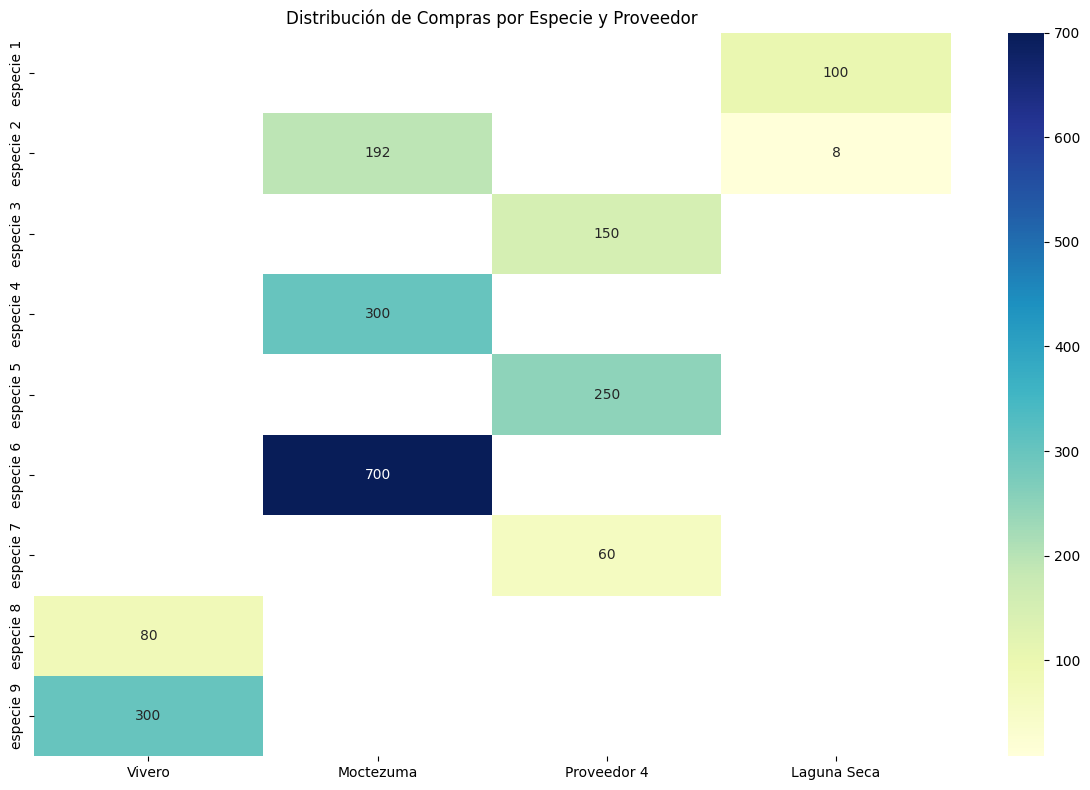

In [13]:
import pandas as pd
import numpy as np
import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Cargar datos correctamente considerando la estructura específica del CSV
costos_proveedor = pd.read_csv('CostosEspeciesProveedores.csv', header=None)

# Extraer nombres de proveedores (primera fila, saltando primera celda que es NaN)
nombres_proveedores = costos_proveedor.iloc[0, 1:].tolist()

# Extraer nombres de especies (primera columna, saltando primera celda)
nombres_especies = costos_proveedor.iloc[1:, 0].tolist()

# Extraer matriz de costos (convertir a float)
matriz_costos = costos_proveedor.iloc[1:, 1:].values.astype(float)

# Definir constantes
costo_transporte = 4500
demanda_especies = [100, 200, 150, 300, 250, 700, 60, 80, 300]  # Demanda de cada especie
num_especies = len(demanda_especies)
num_proveedores = matriz_costos.shape[1]

# Verificar dimensiones
if num_especies != len(nombres_especies):
    print(f"¡Advertencia! El número de especies ({num_especies}) no coincide con los nombres disponibles ({len(nombres_especies)})")

def calcular_costo_total(solucion):
    """
    Calcula el costo total de una solución
    
    Args:
        solucion: Matriz donde cada fila es una especie y cada columna es un proveedor.
                 Los valores representan la cantidad de especies i compradas al proveedor j.
    
    Returns:
        costo_total: Costo total de la solución
    """
    # Costo de compra de especies
    costo_compra = np.sum(solucion * matriz_costos)
    
    # Número de proveedores utilizados (si alguna especie > 0)
    proveedores_utilizados = np.sum(np.any(solucion > 0, axis=0))
    
    # Costo de transporte
    costo_trans = costo_transporte * proveedores_utilizados
    
    return costo_compra + costo_trans

def solucion_factible(solucion):
    """
    Verifica si una solución es factible (cumple con la demanda de todas las especies)
    """
    # Sumar la cantidad de cada especie comprada a todos los proveedores
    cantidad_especies = np.sum(solucion, axis=1)
    
    # Verificar si se satisface la demanda de cada especie
    return np.all(cantidad_especies >= demanda_especies)

def solucion_greedy():
    """
    Genera una solución greedy básica
    """
    # Inicializar matriz de solución con ceros
    solucion = np.zeros((num_especies, num_proveedores))
    
    # Para cada especie, elegir el proveedor más barato
    for especie in range(num_especies):
        # Ordenar proveedores por costo para esta especie
        proveedores_ordenados = np.argsort(matriz_costos[especie])
        
        # Asignar toda la demanda al proveedor más barato
        solucion[especie, proveedores_ordenados[0]] = demanda_especies[especie]
    
    return solucion

# Solución mejorada considerando consolidación de proveedores
def solucion_greedy_mejorada():
    """
    Genera una solución greedy mejorada que intenta consolidar proveedores
    """
    # Inicializar matriz de solución con ceros
    solucion = np.zeros((num_especies, num_proveedores))
    
    # Calcular un "score" para cada proveedor basado en su ranking de precios para todas las especies
    rankings = np.zeros(num_proveedores)
    
    for especie in range(num_especies):
        # Obtener ranking de proveedores para esta especie (menor costo = mejor ranking)
        ranking_especie = np.argsort(np.argsort(matriz_costos[especie]))
        rankings += ranking_especie * demanda_especies[especie]  # Ponderar por demanda
    
    # Ordenar proveedores por score total (menor es mejor)
    proveedores_ordenados = np.argsort(rankings)
    
    # Intentar asignar demanda a los proveedores en orden de su score total
    especies_no_asignadas = list(range(num_especies))
    
    for proveedor in proveedores_ordenados:
        if not especies_no_asignadas:
            break  # Todas las especies han sido asignadas
            
        # Ordenar especies por costo para este proveedor
        especies_ordenadas = sorted(especies_no_asignadas, 
                                   key=lambda e: matriz_costos[e, proveedor])
        
        for especie in especies_ordenadas:
            # Si el costo es razonable (no es 10000), asignar la demanda
            if matriz_costos[especie, proveedor] < 9999:
                solucion[especie, proveedor] = demanda_especies[especie]
                especies_no_asignadas.remove(especie)
    
    # Si quedan especies sin asignar, usar el enfoque greedy básico para ellas
    for especie in especies_no_asignadas:
        proveedor = np.argmin(matriz_costos[especie])
        solucion[especie, proveedor] = demanda_especies[especie]
    
    return solucion

# Eliminar la definición anterior de creator si existe
if 'FitnessMin' in dir(creator):
    del creator.FitnessMin
if 'Individual' in dir(creator):
    del creator.Individual

# Configuración del algoritmo genético
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimizar
creator.create("Individual", list, fitness=creator.FitnessMin)

def flatten_matrix(matriz):
    """Convierte una matriz en una lista unidimensional"""
    return matriz.flatten().tolist()

def unflatten_matrix(lista):
    """Convierte una lista unidimensional en una matriz"""
    return np.array(lista).reshape(num_especies, num_proveedores)

def crear_individuo():
    """
    Crea un individuo aleatorio que cumpla con las restricciones de demanda
    """
    individuo = np.zeros((num_especies, num_proveedores))
    
    # Lista de proveedores preferidos (costos bajos)
    proveedores_preferidos = []
    for especie in range(num_especies):
        # Obtener los 2 mejores proveedores para cada especie
        mejores = np.argsort(matriz_costos[especie])[:2]
        proveedores_preferidos.extend(mejores)
    
    # Contar frecuencias
    contador = {}
    for p in proveedores_preferidos:
        contador[p] = contador.get(p, 0) + 1
    
    # Ordenar por frecuencia (los más comunes primero)
    proveedores_ordenados = sorted(contador.keys(), key=lambda x: contador[x], reverse=True)
    
    # Usar proveedores comunes con más frecuencia
    for especie in range(num_especies):
        demanda_restante = demanda_especies[especie]
        
        # Intentar primero con los proveedores comunes
        for proveedor in proveedores_ordenados:
            if matriz_costos[especie, proveedor] < 9999:  # Si no es un costo prohibitivo
                # Asignar aleatoriamente entre 0 y la demanda restante
                if random.random() < 0.7:  # 70% de probabilidad de usar este proveedor
                    cantidad = random.randint(0, demanda_restante)
                    individuo[especie, proveedor] = cantidad
                    demanda_restante -= cantidad
            
            if demanda_restante == 0:
                break
        
        # Si queda demanda sin asignar, usar proveedores aleatorios
        if demanda_restante > 0:
            proveedores_disponibles = list(range(num_proveedores))
            random.shuffle(proveedores_disponibles)
            
            for proveedor in proveedores_disponibles:
                if matriz_costos[especie, proveedor] < 9999:  # Evitar costos prohibitivos
                    individuo[especie, proveedor] += demanda_restante
                    break
            
            # Si no se pudo asignar a ningún proveedor con costo razonable, usar el mejor disponible
            if demanda_restante > 0:
                mejor_proveedor = np.argmin(matriz_costos[especie])
                individuo[especie, mejor_proveedor] += demanda_restante
    
    return flatten_matrix(individuo)

def evaluar_individuo(individuo):
    """Evalúa el costo total de un individuo"""
    matriz = unflatten_matrix(individuo)
    
    # Verificar que se cumplen las demandas
    for especie in range(num_especies):
        total = sum(matriz[especie])
        if abs(total - demanda_especies[especie]) > 0.01:  # permitir pequeño error de redondeo
            return (float('inf'),)  # Penalizar soluciones inválidas
    
    return (calcular_costo_total(matriz),)

def cruzar_individuos(ind1, ind2):
    """Cruza dos individuos respetando las restricciones de demanda"""
    ind1_matriz = unflatten_matrix(ind1)
    ind2_matriz = unflatten_matrix(ind2)
    
    # Para cada especie, elegimos aleatoriamente entre las soluciones de ambos padres
    for especie in range(num_especies):
        if random.random() < 0.5:
            ind1_matriz[especie], ind2_matriz[especie] = ind2_matriz[especie].copy(), ind1_matriz[especie].copy()
    
    # Verificar que las restricciones de demanda se cumplen
    for matriz in [ind1_matriz, ind2_matriz]:
        for especie in range(num_especies):
            total_especie = np.sum(matriz[especie])
            if abs(total_especie - demanda_especies[especie]) > 0.01:  # permitir pequeño error de redondeo
                # Ajustar para cumplir con la demanda
                if total_especie > demanda_especies[especie]:
                    # Reducir el exceso
                    exceso = total_especie - demanda_especies[especie]
                    # Reducir del proveedor más caro
                    while exceso > 0:
                        # Encontrar proveedor con alguna asignación
                        proveedores_con_asignacion = np.where(matriz[especie] > 0)[0]
                        if len(proveedores_con_asignacion) == 0:
                            break
                            
                        # Entre los que tienen asignación, elegir el más caro
                        idx_max = proveedores_con_asignacion[np.argmax(matriz_costos[especie, proveedores_con_asignacion])]
                        reduccion = min(matriz[especie, idx_max], exceso)
                        matriz[especie, idx_max] -= reduccion
                        exceso -= reduccion
                else:
                    # Aumentar el déficit
                    deficit = demanda_especies[especie] - total_especie
                    # Aumentar en el proveedor más barato
                    idx_min = np.argmin(matriz_costos[especie])
                    matriz[especie, idx_min] += deficit
    
    # Crear objetos Individual adecuados para DEAP
    child1 = creator.Individual(flatten_matrix(ind1_matriz))
    child2 = creator.Individual(flatten_matrix(ind2_matriz))
    
    return child1, child2

def mutar_individuo(individuo):
    """
    Muta un individuo redistribuyendo la demanda de una especie aleatoria
    """
    matriz = unflatten_matrix(individuo)
    
    # Seleccionar especies a mutar (entre 1 y 3)
    num_especies_mutar = random.randint(1, min(3, num_especies))
    especies_a_mutar = random.sample(range(num_especies), num_especies_mutar)
    
    for especie in especies_a_mutar:
        # Elegir estrategia de mutación
        estrategia = random.choice(['redistribuir', 'consolidar', 'diversificar'])
        
        if estrategia == 'redistribuir':
            # Redistribuir aleatoriamente
            nueva_distribucion = np.zeros(num_proveedores)
            demanda = demanda_especies[especie]
            
            # Asignar cantidades aleatorias a proveedores con costos razonables
            proveedores_razonables = [p for p in range(num_proveedores) if matriz_costos[especie, p] < 9999]
            
            if not proveedores_razonables:  # Si no hay proveedores razonables
                proveedores_razonables = [np.argmin(matriz_costos[especie])]
            
            for i in range(len(proveedores_razonables) - 1):
                if demanda <= 0:
                    break
                proveedor = proveedores_razonables[i]    
                cantidad = random.randint(0, demanda)
                nueva_distribucion[proveedor] = cantidad
                demanda -= cantidad
            
            # Asignar el resto al último proveedor razonable
            if proveedores_razonables:
                nueva_distribucion[proveedores_razonables[-1]] = demanda
            
            # Actualizar la matriz
            matriz[especie] = nueva_distribucion
            
        elif estrategia == 'consolidar':
            # Consolidar en el proveedor más barato
            mejor_proveedor = np.argmin(matriz_costos[especie])
            matriz[especie] = np.zeros(num_proveedores)
            matriz[especie, mejor_proveedor] = demanda_especies[especie]
            
        else:  # diversificar
            # Diversificar entre varios proveedores
            proveedores_razonables = [p for p in range(num_proveedores) if matriz_costos[especie, p] < 9999]
            
            if len(proveedores_razonables) <= 1:
                continue  # No se puede diversificar
                
            matriz[especie] = np.zeros(num_proveedores)
            demanda = demanda_especies[especie]
            cantidad_por_proveedor = demanda // len(proveedores_razonables)
            resto = demanda % len(proveedores_razonables)
            
            for p in proveedores_razonables:
                matriz[especie, p] = cantidad_por_proveedor
            
            # Distribuir el resto
            for i in range(resto):
                matriz[especie, proveedores_razonables[i]] += 1
    
    # Crear y devolver un objeto Individual adecuado para DEAP
    mutated = creator.Individual(flatten_matrix(matriz))
    return (mutated,)

def inicializar_ga():
    """Inicializa y ejecuta el algoritmo genético"""
    toolbox = base.Toolbox()
    
    # Registrar funciones
    toolbox.register("individual", tools.initIterate, creator.Individual, crear_individuo)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", evaluar_individuo)
    toolbox.register("mate", cruzar_individuos)
    toolbox.register("mutate", mutar_individuo)
    toolbox.register("select", tools.selTournament, tournsize=3)
    
    # Crear población inicial
    pop_size = 100
    population = toolbox.population(n=pop_size)
    
    # Añadir soluciones greedy a la población inicial
    sol_greedy = flatten_matrix(solucion_greedy())
    sol_greedy_mejorada = flatten_matrix(solucion_greedy_mejorada())
    
    population[0] = creator.Individual(sol_greedy)
    population[1] = creator.Individual(sol_greedy_mejorada)
    
    # Parámetros
    n_gen = 50  # Generaciones
    p_crossover = 0.7
    p_mutate = 0.2
    
    # Estadísticas
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    
    # Ejecutar algoritmo
    hof = tools.HallOfFame(5)  # Guardamos las 5 mejores soluciones
    result, log = algorithms.eaSimple(population, toolbox, 
                                     cxpb=p_crossover, mutpb=p_mutate, 
                                     ngen=n_gen, stats=stats, 
                                     halloffame=hof, verbose=True)
    
    return hof, log

def analizar_solucion(solucion, nombre=""):
    """Analiza y muestra información detallada sobre una solución"""
    costo = calcular_costo_total(solucion)
    
    proveedores_usados = np.any(solucion > 0, axis=0)
    num_proveedores = np.sum(proveedores_usados)
    
    costo_compra = np.sum(solucion * matriz_costos)
    costo_trans = costo_transporte * num_proveedores
    
    print(f"\n--- Análisis de Solución {nombre} ---")
    print(f"Costo total: {costo:.2f}")
    print(f"Costo de compra: {costo_compra:.2f}")
    print(f"Costo de transporte: {costo_trans:.2f}")
    print(f"Número de proveedores utilizados: {num_proveedores}")
    
    # Mostrar qué proveedores se usan
    print("\nProveedores utilizados:")
    for i, usado in enumerate(proveedores_usados):
        if usado:
            nombre_proveedor = nombres_proveedores[i] if i < len(nombres_proveedores) else f"Proveedor {i}"
            print(f"- {nombre_proveedor}")
    
    return costo, num_proveedores, costo_compra, costo_trans

def visualizar_distribucion(solucion):
    """Visualiza la distribución de compras por especie y proveedor"""
    plt.figure(figsize=(12, 8))
    
    # Crear una máscara para valores mayores a cero
    mask = solucion > 0
    
    # Crear etiquetas para el heatmap
    if len(nombres_especies) == num_especies and len(nombres_proveedores) == num_proveedores:
        rows = nombres_especies
        cols = nombres_proveedores
    else:
        rows = [f"Especie {i}" for i in range(num_especies)]
        cols = [f"Proveedor {i}" for i in range(num_proveedores)]
    
    # Crear un dataframe para seaborn
    df = pd.DataFrame(solucion, index=rows, columns=cols)
    
    # Crear heatmap
    sns.heatmap(df, annot=True, fmt='.0f', cmap='YlGnBu', mask=(~mask))
    plt.title('Distribución de Compras por Especie y Proveedor')
    plt.tight_layout()
    plt.show()

def optimizar_proveedores():
    """Función principal para optimizar la selección de proveedores"""
    print("Generando soluciones iniciales...")
    
    # Solución greedy básica
    solucion_inicial = solucion_greedy()
    costo_greedy, num_prov_greedy, _, _ = analizar_solucion(solucion_inicial, "Greedy Básica")
    
    # Solución greedy mejorada
    solucion_mejorada = solucion_greedy_mejorada()
    costo_mejorado, num_prov_mejorado, _, _ = analizar_solucion(solucion_mejorada, "Greedy Mejorada")
    
    print("\nEjecutando algoritmo genético...")
    hof, log = inicializar_ga()
    
    # Analizar la mejor solución del algoritmo genético
    mejor_individuo = hof[0]
    mejor_solucion = unflatten_matrix(mejor_individuo)
    costo_ga, num_prov_ga, _, _ = analizar_solucion(mejor_solucion, "Algoritmo Genético")
    
    # Comparar soluciones
    print("\n--- Comparación de Soluciones ---")
    print(f"Greedy Básica: {costo_greedy:.2f} (con {num_prov_greedy} proveedores)")
    print(f"Greedy Mejorada: {costo_mejorado:.2f} (con {num_prov_mejorado} proveedores)")
    print(f"Algoritmo Genético: {costo_ga:.2f} (con {num_prov_ga} proveedores)")
    
    # Detallar la distribución de la compra en la mejor solución
    print("\n--- Distribución Detallada de Compras (Mejor Solución) ---")
    for especie in range(num_especies):
        nombre_especie = nombres_especies[especie] if especie < len(nombres_especies) else f"Especie {especie}"
        print(f"\n{nombre_especie}:")
        for proveedor in range(num_proveedores):
            if mejor_solucion[especie, proveedor] > 0:
                nombre_proveedor = nombres_proveedores[proveedor] if proveedor < len(nombres_proveedores) else f"Proveedor {proveedor}"
                print(f"  - Comprar {int(mejor_solucion[especie, proveedor])} unidades a {nombre_proveedor} " +
                      f"(costo unitario: {matriz_costos[especie, proveedor]:.2f})")
    
    # Visualizar evolución del algoritmo
    gen = log.select("gen")
    min_fit = log.select("min")
    avg_fit = log.select("avg")
    std_fit = log.select("std")
    
    plt.figure(figsize=(10, 6))
    plt.plot(gen, min_fit, 'b-', label='Mejor fitness')
    plt.plot(gen, avg_fit, 'r-', label='Fitness promedio')
    plt.fill_between(gen, np.array(avg_fit) - np.array(std_fit), 
                    np.array(avg_fit) + np.array(std_fit), 
                    alpha=0.2, color='r')
    plt.xlabel('Generación')
    plt.ylabel('Costo')
    plt.title('Evolución del Algoritmo Genético')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Visualizar la distribución de compras
    visualizar_distribucion(mejor_solucion)
    
    return mejor_solucion, costo_ga

# Ejecutar optimización
if __name__ == "__main__":
    mejor_solucion, mejor_costo = optimizar_proveedores()